## Load and explore Purkinje locomotion data set

In [1]:
import h5py
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [2]:
def Load_Dict_from_HDF5(filename, attrs=False):
    # Modified from: https://codereview.stackexchange.com/questions/120802
    # attrs: (Default False) If True, the routine will also load the attributes of each object.
    #        If "Root", it will only load the attributes of the first file node.

    def recursively_load_dict_contents_from_group(h5file, path, attrs):
        ans = {}
        if len(ans) == 0 and not attrs is False:
            ans["Root Attrs"] = {key:(elem if not isinstance(elem, h5py._hl.base.Empty) else []) for key, elem in dict(h5file['/'].attrs).items()}
            if "oo" in attrs: attrs = False
        for key, item in h5file[path].items():
            if isinstance(item, h5py._hl.dataset.Dataset):
                ans[key] = item[()]
                if attrs: ans["%s_Attrs" % key] = dict(item.attrs)
            elif isinstance(item, h5py._hl.base.Empty):
                ans[key] = []
            elif isinstance(item, h5py._hl.group.Group):
                ans[key] = recursively_load_dict_contents_from_group(h5file, path + key + '/', attrs)
                if attrs: ans[key]["Attrs"] = dict(item.attrs)
        return ans

    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents_from_group(h5file, '/', attrs)


In [3]:
#filename='../data/EncDec_NLT_AddT_spth0-0.h5'
filename='../data/EncDec_NLT_AddT_spth0d05-0d5.h5'
data = Load_Dict_from_HDF5(filename)

In [4]:
data.keys()

dict_keys(['Locomotion Reference', 'Pseudo-Predictions'])

In [5]:
data['Pseudo-Predictions'].keys()

dict_keys(['Cell Names', 'Identifier', 'Legend matrix', 'Matrix'])

In [6]:
data['Pseudo-Predictions']['Legend matrix']

b"Axis 0: Datapoints\nAxis 1: variables of the pseudo-predictions (0-3: limbs FR-HR-FL-HL terms respectively, 4: nonlinear limb term, 5: sum of all other terms)\nAxis 2: Neurons (lookup table of identity in 'Cell Names')"

4 linear, 1 nonlinear and 1 nuisance component. All components together are the original firing rate of each neuron. We will use the sum of the 1st 5 (i.e. linear and nonliear) components, that is without the nuisance component.

In [7]:
data['Pseudo-Predictions']['Matrix'].shape # time points x features x neurons

(1816281, 6, 105)

In [8]:
data['Locomotion Reference'].keys()

dict_keys(['4D-phase Trig. Decomp.', 'Acq. Freq.', 'Global Phase 4D distance', 'Global Phase PCA embeddings', 'Original Sessions of Behavioral Reference', 'PCA selected embeddings and rotation sense', 'PCA-phase Trig. Decomp.', 'Phaser-phase Trig. Decomp.', 'Phases', 'Significance Cross-val. Tests', 'Significance Indexing Lookup', 'Wheel Speed', 'X-accel Matrix', 'X-pos Matrix', 'X-speed Matrix', 'Y-accel Matrix', 'Y-pos Matrix', 'Y-speed Matrix', 'Z-accel Matrix', 'Z-pos Matrix', 'Z-speed Matrix'])

First selection is cells that could be tested / could be cross-validated (105 --> 103 cells passed)

In [20]:
selection_1 = data['Locomotion Reference']['Significance Indexing Lookup']
selection_1

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104])

Second selection is cells that are then actually sigificant according to cross-validation test (103 --> 91 cells), i.e. significant modulation to locomotion (limb movement).

In [21]:
selection_2 = data['Locomotion Reference']['Significance Cross-val. Tests']['Locomotion_signif']
selection_2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
# Check:
sum(data['Locomotion Reference']['Significance Cross-val. Tests']['Locomotion_signif'])

91

In [23]:
data['Locomotion Reference']['Y-pos Matrix'].shape # time points x #limbs

(1816281, 4)

In [24]:
data['Locomotion Reference']['Wheel Speed'].shape # time points x #limbs

(1816281,)

Front right limb movement (x-axis) :

In [26]:
data['Locomotion Reference'].keys()

dict_keys(['4D-phase Trig. Decomp.', 'Acq. Freq.', 'Global Phase 4D distance', 'Global Phase PCA embeddings', 'Original Sessions of Behavioral Reference', 'PCA selected embeddings and rotation sense', 'PCA-phase Trig. Decomp.', 'Phaser-phase Trig. Decomp.', 'Phases', 'Significance Cross-val. Tests', 'Significance Indexing Lookup', 'Wheel Speed', 'X-accel Matrix', 'X-pos Matrix', 'X-speed Matrix', 'Y-accel Matrix', 'Y-pos Matrix', 'Y-speed Matrix', 'Z-accel Matrix', 'Z-pos Matrix', 'Z-speed Matrix'])

Text(0, 0.5, 'Front right limb position')

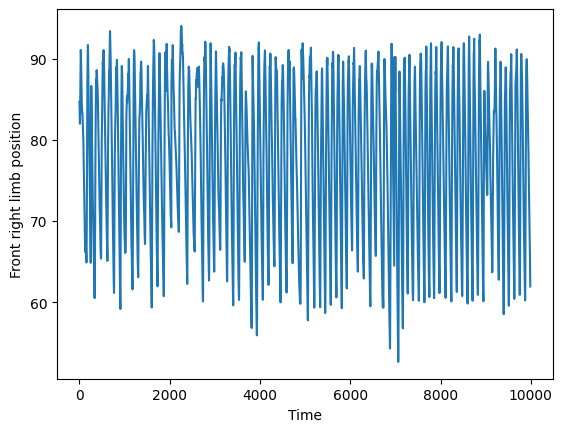

In [27]:
plt.plot(data['Locomotion Reference']['X-pos Matrix'][10:10000,0])
plt.xlabel('Time')
plt.ylabel('Front right limb position')

In [30]:
data['Pseudo-Predictions'].keys()

dict_keys(['Cell Names', 'Identifier', 'Legend matrix', 'Matrix'])

- Sum of individual limb terms (no cross-terms / nonlinear interaction / ti() term in gam ) . Those smooths in the gam.
- Nonlinear / cross - term
- Total sum (linear + nonlinear)

Text(0, 0.5, 'Firing rate 1st neuron')

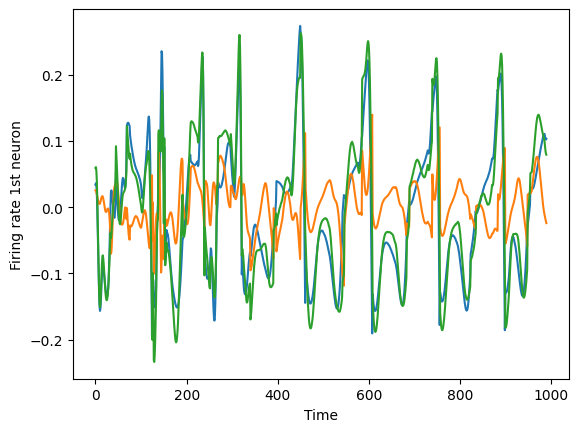

In [36]:
plt.plot(data['Pseudo-Predictions']['Matrix'][10:1000,0:4,0].sum(axis=1))
plt.plot(data['Pseudo-Predictions']['Matrix'][10:1000,4,0])
plt.plot(data['Pseudo-Predictions']['Matrix'][10:1000,0:5,0].sum(axis=1))
plt.xlabel('Time')
plt.ylabel('Firing rate 1st neuron')

In [89]:
X = data['Pseudo-Predictions']['Matrix'][:,:,selection_1][:,:,selection_2.astype('bool')]
cell_names = data['Pseudo-Predictions']['Cell Names'][selection_1][selection_2.astype('bool')]
cell_names = np.array([x.decode('utf-8') for x in cell_names])
X.shape

(1816281, 6, 91)

In [90]:
locomotion_names=[]
limbs=['FR','HR','FL','HL']
selected_features = ['X-pos','Z-pos','X-speed','Z-speed']
Y = []
for feature in data['Locomotion Reference'].keys():
    if not any([lm in feature for lm in selected_features]):
        continue
    Y.append(data['Locomotion Reference'][feature])
    for limb in limbs:
        locomotion_names.append(feature[:3]+' '+limb)
    
Y = np.concatenate(Y, axis=1)
Y.shape

(1816281, 16)

In [91]:
X_linear = X[:,:4,:].sum(axis=1)
X_nonlinear = X[:,4,:]
X_full = X[:,:5,:].sum(axis=1)

purkinjedata = {
    'Linear mix':X_linear,
    'Nonlinear only':X_nonlinear,
    'Full mixing':X_full,
    'Locomotion':Y,
    'cell_names':cell_names,
    'locomotion_names':locomotion_names,
    'sampling rate (Hz)': 330
    }
pickle.dump(purkinjedata, open('../data/purkinje_sRRR.pickle', 'wb'))

In [92]:
# double check
print('Number of time points: ', X.shape[0])
print('Number of neurons: ', X.shape[2])
print('Number of locomotion features: ', Y.shape[1])
print('X and Y shapes: ', X.shape, Y.shape)
print('Neuron names: ', cell_names[:10], ' ...')
print('Locomotion features: ', locomotion_names)

Number of time points:  1816281
Number of neurons:  91
Number of locomotion features:  16
X and Y shapes:  (1816281, 6, 91) (1816281, 16)
Neuron names:  ['MC3808_S1' 'MC3808_S2' 'MC3808_S3' 'MC3808_S4' 'MC3808_S5' 'MC3808_S6'
 'MC3808_S7' 'MC3810_S10' 'MC3810_S11' 'MC3810_S2']  ...
Locomotion features:  ['X-p FR', 'X-p HR', 'X-p FL', 'X-p HL', 'X-s FR', 'X-s HR', 'X-s FL', 'X-s HL', 'Z-p FR', 'Z-p HR', 'Z-p FL', 'Z-p HL', 'Z-s FR', 'Z-s HR', 'Z-s FL', 'Z-s HL']
